<h2> Import Packages </h2>

In [353]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from datetime import datetime as dt
import os
from termcolor import colored
import lightgbm
from sklearn.metrics import mean_absolute_error
import warnings
import dill
import datetime
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
path = r'C:\Users\gaurav.gund\OneDrive - Grant Thornton Advisory Private Limited\Documents\d_drive\C Drive Backup 2021\Desktop\hackathon\niologic'

<h2> Read Data </h2>

In [3]:
os.chdir(path)
data = pd.read_csv('Seattle_Real_Time_Fire_911_Calls.csv')

In [5]:
data.shape

(1659898, 7)

In [4]:
data.head(3)

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number
0,904 7th Av,Car Fire,05/22/2019 12:55:00 PM,47.606900,-122.329051,POINT (-122.329051 47.6069),F190051945
1,9610 53rd Av S,Aid Response,05/22/2019 12:55:00 PM,47.515984,-122.266529,POINT (-122.266529 47.515984),F190051946
2,106 Pike St,Aid Response,05/22/2019 12:57:00 PM,47.608849,-122.339945,POINT (-122.339945 47.608849),F190051950


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659898 entries, 0 to 1659897
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Address          1659822 non-null  object 
 1   Type             1659898 non-null  object 
 2   Datetime         1659898 non-null  object 
 3   Latitude         1658959 non-null  float64
 4   Longitude        1658959 non-null  float64
 5   Report Location  1658995 non-null  object 
 6   Incident Number  1659898 non-null  object 
dtypes: float64(2), object(5)
memory usage: 88.6+ MB


<h2> Exploratory Analysis </h2>

<h3> Unique Incident Number </h3>

In [305]:

print(colored('Incident Number has length :' + str(len(data['Incident Number'].unique()))+'Hence, they are unique.', 'blue'))

Incident Number has length :1659898Hence, they are unique.


<h3> Observation by Year </h3>

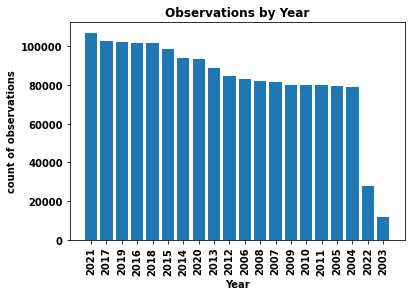

In [323]:
abc1 = data['Datetime'].apply(lambda x:x.split('/')[2].split(' ')[0] ).value_counts().reset_index()
abc1.columns=['Year', 'count of observations']
plt.bar(abc1.Year, abc1['count of observations'])
plt.title('Observations by Year')
plt.xlabel('Year')
plt.ylabel( 'count of observations')
plt.xticks(rotation= 'vertical')
plt.show()

<h3> Type of calls </h3>

In [320]:
print(colored('Type has length :' + str(len(data['Type'].unique())), 'blue'))

Type has length :245


<h3> Selecting data for last 5 year </h3>

In [314]:
data['Year'] = data['Datetime'].apply(lambda x:x.split('/')[2].split(' ')[0] )
data1 = data[data.Year.isin(['2016', '2017','2018', '2019', '2020', '2021'])]

In [364]:
print(colored('Shape of data is :' + str(data1.shape), 'blue'))

Shape of data is :(609306, 8)


In [316]:
data1.head(2)

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,Year
0,904 7th Av,Car Fire,05/22/2019 12:55:00 PM,47.606900,-122.329051,POINT (-122.329051 47.6069),F190051945,2019
1,9610 53rd Av S,Aid Response,05/22/2019 12:55:00 PM,47.515984,-122.266529,POINT (-122.266529 47.515984),F190051946,2019


<h2> Data Preparation </h2>

In [25]:
data2 = data1.drop(['Address', 'Report Location', 'Incident Number'], axis= 1)

In [26]:
data2.head(2)

,Type,Datetime,Latitude,Longitude,Year
0,Car Fire,05/22/2019 12:55:00 PM,47.606900,-122.329051,2019
1,Aid Response,05/22/2019 12:55:00 PM,47.515984,-122.266529,2019


<h3> Missing Data Check  </h3>

In [365]:
print(data2.isnull().sum(axis= 0))
print(' ')
print(colored('There are 852 cases where Latitude and Longitude are missing','blue') )

Type           0
Datetime       0
Latitude     852
Longitude    852
Year           0
dtype: int64
 
There are 852 cases where Latitude and Longitude are missing


In [366]:
data2[data2.Latitude.isnull()].head(2)

,Type,Datetime,Latitude,Longitude,Year
767,Automatic Medical Alarm,04/25/2019 09:49:00 AM,NaN,NaN,2019
768,Aid Response,04/25/2019 09:51:00 AM,NaN,NaN,2019


<h1> Experiment 1: Daily predictions </h1>

<h3> <font color="blue"> This involves predicting calls on everyday basis by Locations  </font></h3>

<h2> Experiment 1: Data Split </h2>

In [214]:
test= data2[data2.Year.isin(['2021'])]
train = data2[~data2.Year.isin(['2021'])]

print(colored('Shape of training data for Experiment 1 is ' + str(train1.shape), 'blue'))
print(colored('Shape of test data for Experiment 1 is ' + str(test1.shape), 'blue'))

Shape of training data for Experiment 1 is (502269, 9)
Shape of test data for Experiment 1 is (107037, 9)


<h2> Experiment 1: Feature Engineering </h2>

<h3> Extract date features </h3>

In [215]:
# convert year into it
train1 = train.copy(deep=True)
train1['Year'] = train1.Year.astype('int')

In [216]:
# extract Month
train1['Month'] = train1.Datetime.apply(lambda x: int(x.split('/')[0]))

In [217]:
# extract day
train1['Day'] = train1.Datetime.apply(lambda x: int(x.split('/')[1]))

In [218]:
# extract hour
train1['hour'] = train1.Datetime.apply(lambda x: int(x.split('/')[2].split(' ')[1].split(':')[0]))

<h5> <font color='blue'> Observation : Tried usig pd.to_datetime but it is very slow </font></h5>

<h3> Extract Season </h3>

In [219]:
# extract season 
def season(month):
    '''Fuction to extract season based on month value '''
    
    if (month == 12 or month ==1 or month == 2):
        return("winter")
        
    elif(month ==3 or month == 4 or month ==  5):
        return "spring"
        
    elif(month ==6 or month==7 or month == 8 ):
        return "summer"
        
    elif(month ==9 or month ==10 or month==11):
        return "Autumn" 

In [220]:
train1['season'] = train1.Month.apply(lambda x: season(x))

<h3> Aggregate Data for prediction: daily predictions </h3>

In [369]:
train1_agg= train1.groupby(['Latitude', 'Longitude', 'Year', 'Month', 'Day', 'season']).size().reset_index()
train1_agg.columns = ['Latitude', 'Longitude', 'Year', 'Month', 'Day','season', 'calls']

In [370]:
train1_agg.head(2)

,Latitude,Longitude,Year,Month,Day,season,calls
0,47.251232,-122.122934,2020,6,3,summer,1
1,47.261880,-122.225729,2019,12,12,winter,1


In [371]:
# one hot encode seasons
train1_agg = pd.get_dummies(train1_agg, columns= ['season'])

In [372]:
train1_agg.head(2)

,Latitude,Longitude,Year,Month,Day,calls,season_Autumn,season_spring,season_summer,season_winter
0,47.251232,-122.122934,2020,6,3,1,0,0,1,0
1,47.261880,-122.225729,2019,12,12,1,0,0,0,1


In [225]:
train1_agg1 = train1_agg.drop(['Year'], axis = 1)

<h3> Prepare test data </h3>

In [327]:
def data_process_first(test1, loc_filter = True):
    '''Function to prepare test data '''
    test1['Year'] = test1['Datetime'].apply(lambda x:x.split('/')[2].split(' ')[0] )
    test1['Year'] = test1.Year.astype('int')
    test1['Month'] =test1.Datetime.apply(lambda x: int(x.split('/')[0]))
    test1['Day'] = test1.Datetime.apply(lambda x: int(x.split('/')[1]))
    test1['hour'] = test1.Datetime.apply(lambda x: int(x.split('/')[2].split(' ')[1].split(':')[0]))
    test1['season'] = test1.Month.apply(lambda x: season(x))
    if loc_filter == True:
        test1_agg= test1.groupby(['Latitude', 'Longitude', 'Year', 'Month', 'Day', 'season']).size().reset_index()
        test1_agg.columns = ['Latitude', 'Longitude', 'Year', 'Month', 'Day','season', 'calls']
    else:
        test1_agg= test1.groupby([ 'Year', 'Month', 'Day', 'season']).size().reset_index()
        test1_agg.columns = [ 'Year', 'Month', 'Day','season', 'calls']
        
    test1_agg = pd.get_dummies(test1_agg, columns= ['season'])
    test1_agg1 = test1_agg.drop(['Year'], axis = 1)
    return(test1_agg1)
    

In [349]:
def results_prep_first(test1, loc_filter = True):
    '''Function to prepare results for dashboard'''
    
    test1['Year'] = test1['Datetime'].apply(lambda x:x.split('/')[2].split(' ')[0] )
    test1['Year'] = test1.Year.astype('int')
    test1['Month'] =test1.Datetime.apply(lambda x: int(x.split('/')[0]))
    test1['Day'] = test1.Datetime.apply(lambda x: int(x.split('/')[1]))
    test1['hour'] = test1.Datetime.apply(lambda x: int(x.split('/')[2].split(' ')[1].split(':')[0]))
    test1['season'] = test1.Month.apply(lambda x: season(x))
    if loc_filter == True:
        test1_agg= test1.groupby(['Latitude', 'Longitude', 'Year', 'Month', 'Day', 'season']).size().reset_index()
        test1_agg.columns = ['Latitude', 'Longitude', 'Year', 'Month', 'Day','season', 'calls']
    else:
        test1_agg= test1.groupby([ 'Year', 'Month', 'Day', 'season']).size().reset_index()
        test1_agg.columns = [ 'Year', 'Month', 'Day','season', 'calls']
        
    
    return(test1_agg)

In [328]:
test1_agg1 = data_process_first(test1, loc_filter = True)

In [329]:
test1_agg1.head(3)

,Latitude,Longitude,Month,Day,calls,season_Autumn,season_spring,season_summer,season_winter
0,47.259911,-121.999790,2,1,1,0,0,0,1
1,47.272963,-122.294079,5,23,1,0,1,0,0
2,47.275077,-122.254463,7,15,1,0,0,1,0


<h2> Experiment 1: Modeling </h2>

In [230]:
y_train1 = train1_agg1.calls
x_train1 = train1_agg1.drop(['calls'], axis= 1)

y_test1 = test1_agg1.calls
x_test1 = test1_agg1.drop(['calls'], axis= 1)

<h3> Lightgbm Regressor training and prediction </h3>

In [231]:
lgbm1 = lightgbm.LGBMRegressor(n_estimators = 300)

In [232]:
lgbm1.fit(x_train1, y_train1)

LGBMRegressor(n_estimators=300)

In [374]:
pred1 = lgbm1.predict(x_test1)
print(colored('Mean Absolute Error on test data is :' +  str(mean_absolute_error(y_test1, pred1)), 'blue'))

Mean Absolute Error on test data is :0.16365566571900106


In [376]:
print(colored('Mean Absolute Error on train data is :' +  str(mean_absolute_error(y_train1,lgbm1.predict(x_train1) )), 'blue'))


Mean Absolute Error on train data is :0.15779555802557307


<h2> Experiment 1: Lightgbm Error Analysis </h2>

In [297]:
df_p1 = pd.DataFrame()
df_p1['actual'] = y_test1
df_p1['predicted']= list(pred1)
df_p1['predicted'] = round(df_p1['predicted'])
df_p1['change_percent'] = abs(df_p1['actual']- df_p1['predicted'])
df_p1.head(3)

,actual,predicted,change_percent
0,1,1.0,0.0
1,1,1.0,0.0
2,1,1.0,0.0


In [377]:
print(colored('Understanding distribution of predictions in test data', 'blue'))
print(' ')
df_p1.predicted.value_counts()

Understanding distribution of predictions in test data
 


1.0    96152
2.0      803
3.0       33
Name: predicted, dtype: int64

In [378]:
print(colored('Understanding distribution of predictions in training data', 'blue'))
print(' ')
df_p1.actual.value_counts()

Understanding distribution of predictions in training data
 


1     88940
2      6753
3      1008
4       197
5        65
6        14
7         9
10        1
8         1
Name: actual, dtype: int64

<h3> <font color="blue">  Observations: The model mostly predict 1,2 and 3 since those are the majority of cases in the training data </font></h3>

In [379]:
print(colored('Understanding distribution of errors in test data', 'blue'))
print(' ')
df_p1.change_percent.quantile([0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

Understanding distribution of errors in test data
 


0.25    0.0
0.50    0.0
0.75    0.0
0.85    0.0
0.95    1.0
0.99    2.0
Name: change_percent, dtype: float64

<h3> <font color="blue">  Observations: The model predicts correctly for 95% of the data </font></h3>

<h3> Generating results for visualisations </h3>

In [354]:
# generate data for visualisation 
results_1 = results_prep_first(test1, loc_filter = True)
results_1['predicted'] = list(pred1)
results_1['predicted'] = round(results_1['predicted'])
results_1['Datetime'] = results_1.apply(lambda x: datetime.date(x['Year'], x['Month'], x['Day']), axis=1)

In [355]:
results_1.head(2)

,Latitude,Longitude,Year,Month,Day,season,calls,predicted,Datetime
0,47.259911,-121.999790,2021,2,1,winter,1,1.0,2021-02-01
1,47.272963,-122.294079,2021,5,23,spring,1,1.0,2021-05-23


In [356]:
#results_1.to_csv('Results1.csv', index = False)

<h1> Experiment 1: Daily predictions without location </h1>

<h3> <font color="blue"> This involves predicting calls on everyday basis without Locations  </font></h3>


<h3> Data Preparation </h3>

In [331]:
test1_agg2 = data_process_first(test1, loc_filter = False)
train1_agg2 = data_process_first(train1, loc_filter = False)


In [333]:
y_train12 = train1_agg2.calls
x_train12 = train1_agg2.drop(['calls'], axis= 1)

y_test12 = test1_agg2.calls
x_test12 = test1_agg2.drop(['calls'], axis= 1)

<h3> Lightgbm: Model training and prediction </h3>

In [334]:
lgbm12 = lightgbm.LGBMRegressor(n_estimators = 300)

In [335]:
lgbm12.fit(x_train12, y_train12)

LGBMRegressor(n_estimators=300)

In [380]:
pred12 = lgbm12.predict(x_test12)

print(colored('Mean Absolute Error on test data is :' +  str(mean_absolute_error(y_test12, pred12)), 'blue'))

Mean Absolute Error on test data is :31.923202796480215


In [381]:
print(colored('Mean Absolute Error on train data is :' +  str(mean_absolute_error(y_train12,lgbm12.predict(x_train12) )), 'blue'))


Mean Absolute Error on train data is :19.986378984910008


<h2> Experiment 1: Lightgbm (without location) Error Analysis </h2>

In [337]:
df_p12 = pd.DataFrame()
df_p12['actual'] = y_test12
df_p12['predicted']= list(pred12)
df_p12['predicted'] = round(df_p12['predicted'])
df_p12['change_percent'] = abs(df_p12['actual']- df_p12['predicted'])
df_p12.head(3)

,actual,predicted,change_percent
0,264,306.0,42.0
1,225,272.0,47.0
2,243,281.0,38.0


In [382]:
print(colored('Understanding distribution of errors in test data', 'blue'))
print(' ')
df_p12.change_percent.quantile([0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

Understanding distribution of errors in test data
 


0.25     13.00
0.50     26.00
0.75     42.00
0.85     52.00
0.95     76.80
0.99    153.08
Name: change_percent, dtype: float64

<h5> <font color="blue"> Observations: Wwithout location gives poor performance in terms of MAE </font></h5>

<h1> Experiment 2: Monthly Predictions </h1>

<h3> <font color="blue"> This involves predicting calls on monthly basis by Locations  </font></h3>

In [243]:
def data_process_monthly(test1):
    '''Function to prepare train and test data '''
    
    if 'Type' in test1.columns:
        test1 = test1.drop(['Type'], axis = 1)
    test1['Year'] = test1['Datetime'].apply(lambda x:x.split('/')[2].split(' ')[0] )
    test1['Year'] = test1.Year.astype('int')
    test1['Month'] =test1.Datetime.apply(lambda x: int(x.split('/')[0]))
  
    test1['season'] = test1.Month.apply(lambda x: season(x))
    test1 = test1.drop(['Datetime'], axis = 1)
    #print(test1.head(2))
    test1_agg= test1.groupby(['Latitude', 'Longitude', 'Year', 'Month', 'season']).size().reset_index()
    
    test1_agg.columns = ['Latitude', 'Longitude', 'Year', 'Month','season', 'calls']
    #print(test1_agg.head(2))
    test1_agg = pd.get_dummies(test1_agg, columns= ['season'])
    test1_agg1 = test1_agg.drop(['Year'], axis = 1)
    return(test1_agg1)

In [358]:
def result_process_monthly(test1):
    '''Function to generate results for dashboard visualisations''' 
    
    if 'Type' in test1.columns:
        test1 = test1.drop(['Type'], axis = 1)
    test1['Year'] = test1['Datetime'].apply(lambda x:x.split('/')[2].split(' ')[0] )
    test1['Year'] = test1.Year.astype('int')
    test1['Month'] =test1.Datetime.apply(lambda x: int(x.split('/')[0]))
  
    test1['season'] = test1.Month.apply(lambda x: season(x))
    test1 = test1.drop(['Datetime'], axis = 1)
    #print(test1.head(2))
    test1_agg= test1.groupby(['Latitude', 'Longitude', 'Year', 'Month', 'season']).size().reset_index()
    
    test1_agg.columns = ['Latitude', 'Longitude', 'Year', 'Month','season', 'calls']
    
    return(test1_agg)

<h3> Train and test preparation </h3>

In [244]:
train2_agg1 = data_process_monthly(train)
test2_agg1 = data_process_monthly(test)

    Latitude   Longitude  Year  Month  season
0  47.606900 -122.329051  2019      5  spring
1  47.515984 -122.266529  2019      5  spring
    Latitude   Longitude  Year  Month  season  calls
0  47.251232 -122.122934  2020      6  summer      1
1  47.261880 -122.225729  2019     12  winter      1
        Latitude   Longitude  Year  Month  season
43660  47.602203 -122.298914  2021      1  winter
43786  47.649847 -122.344754  2021      7  summer
    Latitude   Longitude  Year  Month  season  calls
0  47.259911 -121.999790  2021      2  winter      1
1  47.272963 -122.294079  2021      5  spring      1


In [245]:
train2_agg1.head(2)

,Latitude,Longitude,Month,calls,season_Autumn,season_spring,season_summer,season_winter
0,47.251232,-122.122934,6,1,0,0,1,0
1,47.261880,-122.225729,12,1,0,0,0,1


In [246]:
train2_agg1.shape, train.shape

((279376, 8), (502269, 5))

In [247]:
y_train2 = train2_agg1.calls
x_train2 = train2_agg1.drop(['calls'], axis= 1)

y_test2 = test2_agg1.calls
x_test2 = test2_agg1.drop(['calls'], axis= 1)

<h2> Experiment 2: Model training & Prediction </h2>

In [248]:
lgbm2 = lightgbm.LGBMRegressor(n_estimators = 300)

In [249]:
lgbm2.fit(x_train2, y_train2)

LGBMRegressor(n_estimators=300)

In [383]:
pred2 = lgbm2.predict(x_test2)
print(colored('Mean Absolute Error on test data is :' +  str(mean_absolute_error(y_test2, pred2)), 'blue'))


Mean Absolute Error on test data is :0.9313283223229918


In [385]:
print(colored('Mean Absolute Error on train data is :' +  str(mean_absolute_error(y_train2,lgbm2.predict(x_train2) )), 'blue'))


Mean Absolute Error on train data is :0.8612342212033189


<h2> Experiment 2: LightGBM Error Analysis </h2>

In [293]:
df_p2 = pd.DataFrame()
df_p2['actual'] = y_test2
df_p2['predicted']= list(pred2)
df_p2['predicted']=round(df_p2['predicted'])
df_p2['change_percent'] = abs(df_p1['actual']- df_p1['predicted'])
df_p2.head(3)

,actual,predicted,change_percent
0,1,1.0,0.0
1,1,1.0,0.0
2,1,1.0,0.0


In [386]:
print(colored('Understanding distribution of errors in test data', 'blue'))
print(' ')
df_p2.change_percent.quantile([0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

Understanding distribution of errors in test data
 


0.25    0.0
0.50    0.0
0.75    0.0
0.85    0.0
0.95    1.0
0.99    2.0
Name: change_percent, dtype: float64

In [265]:

df_p2.actual.value_counts()

1     42220
2      7753
3      2969
4      1488
5       911
6       582
7       427
8       313
9       229
10      204
11      150
12      126
13      110
14      100
15       70
16       52
17       45
19       41
18       39
20       32
21       31
22       24
23       22
25       20
27       14
24       13
29       12
26       11
28       11
30       10
31        9
32        7
33        5
39        4
34        3
38        3
35        3
36        3
43        2
37        2
40        2
45        1
61        1
46        1
Name: actual, dtype: int64

In [266]:
df_p2.predicted.value_counts()

1.0     34337
2.0     18346
3.0      2581
4.0       953
5.0       607
6.0       457
8.0       207
7.0       182
9.0       120
12.0       73
10.0       66
11.0       50
21.0       15
13.0       15
31.0       12
14.0        9
20.0        8
18.0        7
43.0        5
17.0        5
47.0        4
23.0        3
16.0        2
50.0        2
32.0        2
0.0         2
45.0        1
22.0        1
39.0        1
19.0        1
52.0        1
Name: predicted, dtype: int64

<h3> Generating results for Visualisation </h3>

In [361]:
results_2 = result_process_monthly(test1)
results_2['predicted'] = list(pred2)
results_2['predicted'] = round(results_2['predicted'])
results_2['Datetime'] = results_2.apply(lambda x: datetime.date(x['Year'], x['Month'], 1), axis=1)

In [362]:
results_2.head(2)

,Latitude,Longitude,Year,Month,season,calls,predicted,Datetime
0,47.259911,-121.999790,2021,2,winter,1,1.0,2021-02-01
1,47.272963,-122.294079,2021,5,spring,1,1.0,2021-05-01


In [363]:
#results_2.to_csv('Results2.csv', index= False)

<h1> Experiment 3: Monthly sales based on previous month data </h1>

<h3> <font color="blue"> This involves predicting calls on monthly based on entire data except last 2 months  </font></h3>


In [281]:
def same_train_test(cols_train, cols_test, test):
    '''Function to ensure train and test has same features'''
    
    # get list of columns not in test
    cols_not_in_test = [i for i in cols_train if i not in cols_test]
    
    # make a column for them with value 0
    if cols_not_in_test:
        for i in cols_not_in_test:
            test[i] = 0
    
    # re-arrange columns based on training data
    test_final = test[cols_train]
    return(test_final)

<h2> Data Preparation </h2>

In [271]:
data3= data2.copy(deep = True)
data3['Month'] = data3.Datetime.apply(lambda x: int(x.split('/')[0]))
test3= data3[(data3.Year.isin(['2021']) & data3.Month.isin([11, 12]))]
train3 = data3[~(data3.Year.isin(['2021']) & data3.Month.isin([11, 12]))]

In [272]:
train3.shape, test3.shape

((590538, 6), (18768, 6))

In [273]:
train3_agg1 = data_process_monthly(train3)
test3_agg1 = data_process_monthly(test3)

    Latitude   Longitude  Year  Month  season
0  47.606900 -122.329051  2019      5  spring
1  47.515984 -122.266529  2019      5  spring
    Latitude   Longitude  Year  Month  season  calls
0  47.251232 -122.122934  2020      6  summer      1
1  47.259911 -121.999790  2021      2  winter      1
         Latitude   Longitude  Year  Month  season
602895  47.617249 -122.347115  2021     11  Autumn
652706  47.545638 -122.362183  2021     12  winter
    Latitude   Longitude  Year  Month  season  calls
0  47.377633 -122.238763  2021     12  winter      1
1  47.445253 -122.291809  2021     12  winter      1


In [282]:
test3_agg1= same_train_test(train3_agg1.columns, test3_agg1.columns, test3_agg1)

In [283]:
y_train3 = train3_agg1.calls
x_train3 = train3_agg1.drop(['calls'], axis= 1)

y_test3= test3_agg1.calls
x_test3 = test3_agg1.drop(['calls'], axis= 1)

<h2> Experiement 3: Model training & Prediction </h2>

In [286]:
lgbm3 = lightgbm.LGBMRegressor(n_estimators = 300)

In [287]:
lgbm3.fit(x_train3, y_train3)

LGBMRegressor(n_estimators=300)

In [388]:
pred3 = lgbm3.predict(x_test3)
print(colored('Mean Absolute Error on test data is :' +  str(mean_absolute_error(y_test3, pred3)), 'blue'))


Mean Absolute Error on test data is :0.9657449328845706


In [387]:
print(colored('Mean Absolute Error on train data is :' +  str(mean_absolute_error(y_train3,lgbm3.predict(x_train3) )), 'blue'))


Mean Absolute Error on train data is :0.8835902047987519


<h2> Experiment 3: Lightgbm Error Analysis </h2>

In [291]:
df_p3 = pd.DataFrame()
df_p3['actual'] = y_test3
df_p3['predicted']= list(pred3)
df_p3['predicted']=round(df_p3['predicted'])
df_p3['change_percent'] = abs(df_p3['actual']- df_p3['predicted'])
df_p3.head(3)

,actual,predicted,change_percent
0,1,1.0,0.0
1,1,2.0,1.0
2,1,1.0,0.0


In [292]:
print(colored('Understanding distribution of errors in test data', 'blue'))
print(' ')
df_p3.change_percent.quantile([0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

0.25     0.0
0.50     0.0
0.75     1.0
0.85     1.0
0.95     3.0
0.99    10.0
Name: change_percent, dtype: float64

In [295]:
print(colored('Understanding distribution of actual in test data', 'blue'))
print(' ')
df_p3.actual.value_counts()

1     7154
2     1372
3      499
4      255
5      150
6       98
7       65
8       48
9       46
10      43
11      30
14      22
12      21
13      17
16      13
17      12
18      11
15       8
20       7
21       7
19       5
22       4
23       4
24       4
27       3
31       3
26       2
29       2
39       2
25       2
40       1
46       1
36       1
34       1
35       1
37       1
30       1
33       1
28       1
32       1
Name: actual, dtype: int64

In [296]:
print(colored('Understanding distribution of predictions in test data', 'blue'))
print(' ')
df_p3.predicted.value_counts()

1.0     5774
2.0     3194
3.0      473
4.0      158
5.0      104
6.0       75
8.0       40
7.0       33
9.0       29
10.0       8
15.0       7
12.0       6
19.0       4
11.0       4
17.0       2
14.0       2
20.0       2
31.0       2
43.0       1
45.0       1
Name: predicted, dtype: int64

<h1> Save models  </h1>

In [303]:
with open('lgbm1_daily', 'wb') as f:
    dill.dump(lgbm1, f)
    
with open('lgbm2_monthly', 'wb') as f:
    dill.dump(lgbm2, f)
    
with open('lgbm3_monthly', 'wb') as f:
    dill.dump(lgbm3, f)

<h1> Observations </h1>
<li> Experiment 1: Daily predictions with location , MAE: 0.163, 95% of predictions were correct </li>
<li> Experiment 1.1:  Daily predictions with location , MAE: 31.9, 25% of predictions were correct </li>
<li> Experiment 2:  Monthly predictions with location , MAE: 0.93, 95% of predictions were correct </li>
<li> Experiment 3:  Monthly predictions with location and all data except last 3 months , MAE: 0.96, 50% of predictions were correct </li>
<li> Accuracy measures ca be checked by collecting demographic data, weather data, population data </li>
        